## Data Import 

In [1]:
import pandas as pd
import numpy as np
import tqdm
import missingno as msno
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.pipeline import Pipeline
from yellowbrick.classifier import ClassificationReport
from yellowbrick.classifier import ConfusionMatrix
from yellowbrick.classifier import ROCAUC
from sklearn.externals import joblib
from scipy.stats import chi2_contingency
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC
import matplotlib.pyplot as plt
import warnings 

data = pd.read_csv('da26521-0003.tsv', sep='\t', header=0)

def replace_missing(x):
    
    if len(str(x)) == 1 and x in [8, 5, 9]:
            return np.nan
        
    if len(str(x)) == 2 and x in [88, 95, 98, 99, 97]:
            return np.nan
        
    if len(str(x)) == 3 and x in [888, 995, 998, 999, 98.0]:
            return np.nan
        
    if len(str(x)) == 4 and x in [88.8, 99.5, 99.8, 8888, 9995, 9998, 9999]:
            return np.nan
        
    if len(str(x)) == 5 and x in [888.8, 999.5, 999.8, 88888, 99995, 99998, 99999]:
            return np.nan
        
    if len(str(x)) == 6 and x in [8888.8, 9999.5, 9999.8]:
            return np.nan    
    
    else:
        return x

data = data.applymap(lambda x: replace_missing(x)).copy()

def list_of_absent_data_columns(data, ratio=0.2):
    """returns list of columns whose missing values make up \
    more than a set ratio (default is half) of the data"""
    variables_list = list(data.columns)
    missing_list = []
    for variable in variables_list:
        missing_ratio = sum(data[variable].isna()) / len(data)
        if missing_ratio > ratio:
            missing_list.append(variable)
    return missing_list

absent_columns = list_of_absent_data_columns(data)

data.drop(columns=absent_columns, inplace=True)

def missing_vis(data):
    """Returns 4 graphics: bar chart, distributions, heatmap \
    (of correlation between nulls), and dendogram"""
    msno.bar(data);
    msno.matrix(data);
    msno.heatmap(data);
    msno.dendrogram(data);


data.shape

singular_variables = []
for col in data.columns:
#     print(col, len(set(prison_data[col])))
    if data[col].nunique() == 1:
        singular_variables.append(col)
print(singular_variables)


data.drop(columns = singular_variables, inplace=True)

data.columns

data.head()

data.shape

data = data.dropna()

data_clean = data[data['V55'] != 10].copy()

data_clean['outcome'] = data_clean['V55'].map(lambda x: 1 if x == 1 else 0)

data_clean['outcome'].value_counts()

data_clean.drop(columns='V55', inplace=True)

data_clean.drop(columns=['V96', 'V97', 'V98', 'V99'], inplace=True)

data_clean.columns

data_clean.shape

variable_names = {'V4': 'case_id',
                  'V8': 'birth_year',
                  'V9': 'sex',
                  'V10': 'race',
                  'V15': 'admission_year',
                  'V24': 'prior_jail_time',
                  'V25': 'prior_prison_time',
                  'V26': 'offense_1',
                  'V32': 'offense_longest_sentence',
                  'V33': 'length_longest_sentence',
                  'V34': 'total_max_sentence_length',
                  'V46': 'year_prison_release',
                  'V48': 'custody_agency_1',
                  'V51': 'release_type',
                  'V56': 'release_supervision_status',
                  'V57': 'age_admission',
                  'V58': 'age_prison_release',
                  'V59': 'age_parole_release',
                  'V62': 'time_served_current_admission',
                  'V67': 'time_served_parole',
                  'V70': 'total_max_sentence_indicator',
                  'V71': 'number_of_offenses_indicator',
                  'V94': 'state'}
variable_categories = {'key': ['case_id'],
                       'datetime': ['birth_year', 'admission_year', 'year_prison_release'],
                       'categorical': ['sex', 'race', 'offense_1', 'offense_longest_sentence', 'custody_agency_1',
                                       'release_type', 'release_supervision_status', 'number_of_offenses_indicator',
                                       'state'],
                       'numeric': ['prior_jail_time', 'prior_prison_time', 'age_admission', 'age_parole_release',
                                   'time_served_current_admission', 'time_served_parole'],
                       'mixed_numeric': ['length_longest_sentence', 'total_max_sentence_length',
                                         'total_max_sentence_indicator']}

descriptive_columns = list(variable_names.values())
descriptive_columns.append('outcome')
data_clean.columns = descriptive_columns
data_clean = pd.get_dummies(data_clean, columns=variable_categories['categorical'], 
                            drop_first=True)

data_clean.drop(columns=['race_2.0', 'race_3.0', 'race_4.0', 'race_6.0', 'sex_2.0'], inplace=True)

In [2]:
data_clean = pd.read_pickle('data_clean.pkl')

In [4]:
data_clean.head()

,case_id,birth_year,admission_year,length_longest_sentence,total_max_sentence_length,year_prison_release,age_admission,age_prison_release,age_parole_release,time_served_current_admission,...,state_40.0,state_41.0,state_47.0,state_48.0,state_49.0,state_51.0,state_53.0,state_54.0,state_55.0,state_58.0
0,1.0,1949.0,2002.0,120.0,120.0,2003.0,53.4,54.6,55.6,14.2,...,0,0,0,0,0,0,0,0,0,0
1,2.0,1948.0,2000.0,180.0,180.0,2004.0,51.4,55.1,55.6,44.8,...,0,0,0,0,0,0,0,0,0,0
2,3.0,1943.0,2000.0,180.0,180.0,2004.0,57.0,60.5,61.1,41.4,...,0,0,0,0,0,0,0,0,0,0
3,4.0,1948.0,1984.0,240.0,240.0,1993.0,36.0,44.5,55.9,102.0,...,0,0,0,0,0,0,0,0,0,0
5,6.0,1950.0,1997.0,300.0,300.0,2003.0,47.7,53.7,54.4,72.0,...,0,0,0,0,0,0,0,0,0,0


In [56]:
data_clean.drop(columns=['case_id', 'time_served_parole', 'age_parole_release'], inplace=True)

## Random Forest Model

In [57]:
X = data_clean.drop(columns='outcome')
y = data_clean['outcome']

In [58]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [59]:
# yellowbrick.ClassBalance().fit(y_train);

### Random Forest Classifier Training

#### Grid Search for Params

In [60]:
# Set parameters for GridSearchCV to investigate

params = {
    'max_features' : ['auto', 'log2'],
    'criterion' : ['gini', 'entropy'],
    'n_estimators' : [150],
    'max_depth' : [1, 10, 100, 1000, None]
}

In [61]:
# Define GridSearchCV Object and Parameters

search = GridSearchCV(estimator=RandomForestClassifier(),
                     scoring='accuracy',
                     param_grid=params,
                     cv=5,
                     return_train_score=True,
                     verbose=True,
                     n_jobs=-1)

In [62]:
# Run the GridSearchCV

warnings.simplefilter('ignore')

# search.fit(X_train, y_train)

In [63]:
# Save GridSearchCV results

filename = 'grid_search_rf.sav'
# joblib.dump(search, filename)

In [64]:
# Find best parameters to use in model 

search = joblib.load('grid_search_rf.sav')
print(search.best_params_, search.best_score_)

AttributeError: 'GridSearchCV' object has no attribute 'best_params_'

#### Random Forest Model

In [65]:
# Set RandomForest model based on GridSearchCV results

rfc = RandomForestClassifier(criterion='entropy', max_depth=100, max_features='auto', n_estimators=150, n_jobs=-1)

In [66]:
# Fit model

rfc.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=100, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=150, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [67]:
features = pd.DataFrame([rfc.feature_importances_, data_clean.columns]).T

In [68]:
features = features.set_index(keys=features[1]).drop(columns=[1])

In [70]:
features.sort_values(by=0, ascending=False)

,0
1,
time_served_current_admission,0.134046
age_admission,0.11077
age_prison_release,0.110445
year_prison_release,0.100586
admission_year,0.0864629
birth_year,0.0762454
length_longest_sentence,0.0542993
total_max_sentence_length,0.0497771
number_of_offenses_indicator_2,0.0483515


In [72]:
# Get train predictions from model

y_train_pred = rfc.predict(X_train)

In [73]:
# Analyze results via confustion matrix

confusion_matrix(y_train, y_train_pred)

array([[59860,     9],
       [   18, 60648]])

In [74]:
# Analyze results via precision/recall/fl_score

print(classification_report(y_train, y_train_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     59869
           1       1.00      1.00      1.00     60666

   micro avg       1.00      1.00      1.00    120535
   macro avg       1.00      1.00      1.00    120535
weighted avg       1.00      1.00      1.00    120535



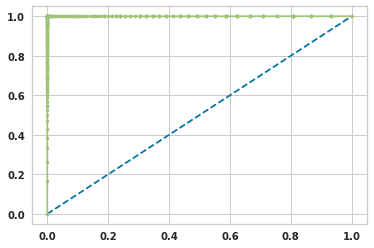

In [75]:
# Graph ROC curve for model

probs_train = rfc.predict_proba(X_train)[:,1]

fpr, tpr, thresholds = roc_curve(y_train, probs_train)
# Plot no skill
plt.plot([0, 1], [0, 1], linestyle='--')
# Plot the roc curve for the model
plt.plot(fpr, tpr, marker='.')
# Show the plot
plt.show()

### Random Forest Classifier Testing

In [76]:
# Get test results

y_test_pred = rfc.predict(X_test)

In [77]:
# Analyze results via confustion matrix

confusion_matrix(y_test, y_test_pred)

array([[16690,  3335],
       [ 4437, 15717]])

In [78]:
# Analyze results via precision/recall/fl_score

print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.79      0.83      0.81     20025
           1       0.82      0.78      0.80     20154

   micro avg       0.81      0.81      0.81     40179
   macro avg       0.81      0.81      0.81     40179
weighted avg       0.81      0.81      0.81     40179



In [79]:
# Graph ROC curve for model

probs_test = rfc.predict_proba(X_test)[:,1]

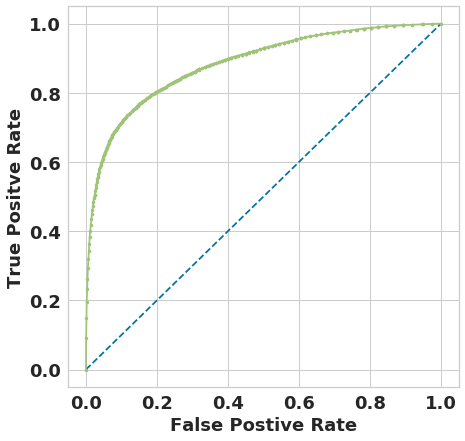

In [80]:
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 18}

plt.rc('font', **font)
plt.figure(figsize=(7,7))
plt.ylabel('True Positve Rate', fontdict=font)
plt.xlabel('False Postive Rate', fontdict=font)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)

fpr, tpr, thresholds = roc_curve(y_test, probs_test)
# plot no skill
plt.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
plt.plot(fpr, tpr, marker='.')

plt.savefig('random_forest_ROC.png', transparent=True)
# show the plot
plt.show()

# plt.savefig('random_forest_ROC.png', transparent=True)

### Bias Analysis

#### Gender Bias

##### False Positives

In [52]:
# Generate Dataframe with results and original dataset

preds = pd.concat([y_test, pd.Series(y_test_pred, name='pred', index=y_test.index), X_test], axis=1, ignore_index=False)

preds = pd.merge(preds, data[['V9', 'V10']], left_index=True, right_index=True)

NameError: name 'data' is not defined

In [53]:
# Calculate sex-based percentage of false positives

sex_false_pos = preds.loc[(preds['outcome'] == 0) & (preds['pred'] == 1)]['V9']

men_false_pos = sum(sex_false_pos == 1)/sum(data['V9'] == 1)

women_false_pos = sum(sex_false_pos == 2)/sum(data['V9'] == 2)

KeyError: 'V9'

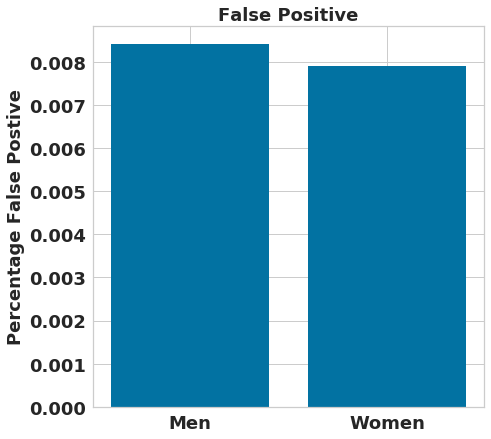

In [151]:
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 18}

plt.rc('font', **font)

plt.figure(figsize=(7,7))
plt.bar(x=['Men', 'Women'], height=[men_false_pos, women_false_pos])
plt.title('False Positive', fontdict=font)
plt.ylabel('Percentage False Postive', fontdict=font)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.savefig('gender_false_pos', transparent=True)

##### False Negatives

In [152]:
# Calculate sex-based percentage of false negatives

sex_false_neg = preds.loc[(preds['outcome'] == 1) & (preds['pred'] == 0)]['V9']

men_false_neg = sum(sex_false_neg == 1)/sum(data['V9'] == 1)

women_false_neg = sum(sex_false_neg == 2)/sum(data['V9'] == 2)

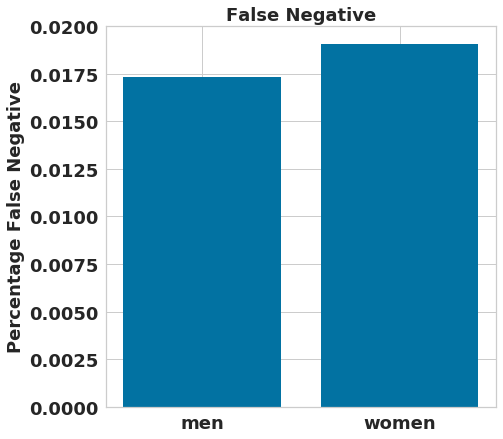

In [153]:
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 18}

plt.rc('font', **font)

plt.figure(figsize=(7,7))
plt.bar(x=['men', 'women'], height=[men_false_neg, women_false_neg])
plt.title('False Negative', fontdict=font)
plt.ylabel('Percentage False Negative', fontdict=font)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.savefig('gender_false_neg', transparent=True)

#### Racial Bias

In [121]:
racial_false_pos = preds.loc[(preds['outcome'] == 0) & (preds['pred'] == 1)]['V10']

white_false_pos = sum(racial_false_pos == 1)/sum(data['V10'] == 1)

black_false_pos = sum(racial_false_pos == 2)/sum(data['V10'] == 2)

americanindian_false_pos = sum(racial_false_pos == 3)/sum(data['V10'] == 3)

asian_false_pos = sum(racial_false_pos == 4)/sum(data['V10'] == 4)

other_false_pos = sum(racial_false_pos == 6)/sum(data['V10'] == 6)

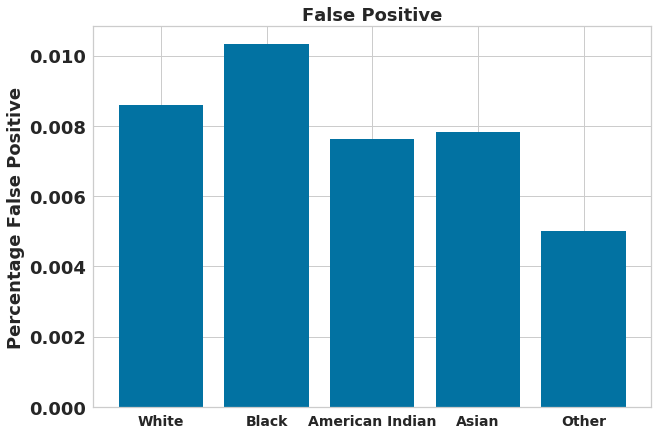

In [149]:
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 18}

plt.rc('font', **font)

plt.figure(figsize=(10,7))

plt.bar(x=['White', 'Black', 'American Indian', 'Asian', 'Other'], 
        height=[white_false_pos,
               black_false_pos,
               americanindian_false_pos,
               asian_false_pos,
               other_false_pos])
plt.title('False Positive', fontdict=font)
plt.ylabel('Percentage False Positive', fontdict=font)
plt.xticks(fontsize=14)
plt.yticks(fontsize=18)
plt.savefig('race_false_pos', transparent=True)

In [131]:
racial_false_neg = preds.loc[(preds['outcome'] == 0) & (preds['pred'] == 1)]['V10']

white_false_neg = sum(racial_false_pos == 1)/sum(data['V10'] == 1)

black_false_neg = sum(racial_false_pos == 2)/sum(data['V10'] == 2)

americanindian_false_neg = sum(racial_false_pos == 3)/sum(data['V10'] == 3)

asian_false_neg = sum(racial_false_pos == 4)/sum(data['V10'] == 4)

other_false_neg = sum(racial_false_pos == 6)/sum(data['V10'] == 6)

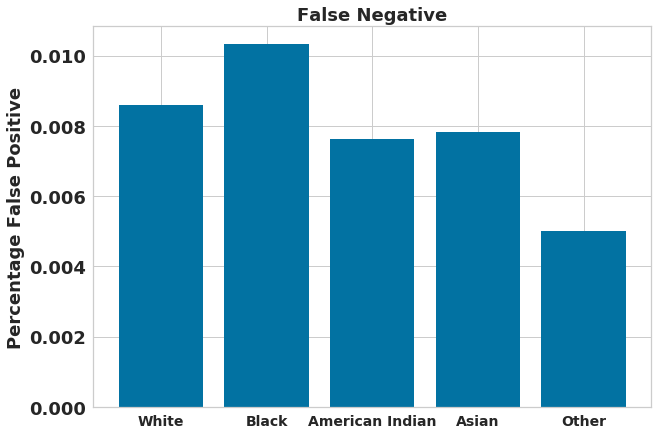

In [150]:
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 18}

plt.rc('font', **font)

plt.figure(figsize=(10,7))

plt.bar(x=['White', 'Black', 'American Indian', 'Asian', 'Other'], 
        height=[white_false_neg,
               black_false_neg,
               americanindian_false_neg,
               asian_false_neg,
               other_false_neg])
plt.title('False Negative', fontdict=font)
plt.ylabel('Percentage False Positive', fontdict=font)
plt.xticks(fontsize=14)
plt.yticks(fontsize=18)
plt.savefig('race_false_neg', transparent=True)

### Model Visualizations

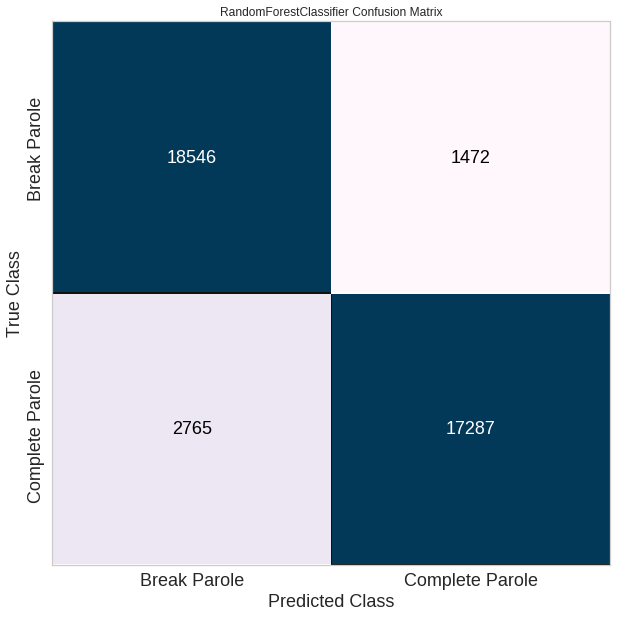

In [167]:
# Plot 

plt.figure(figsize=(10,10))
viz = ConfusionMatrix(RandomForestClassifier(n_estimators=150, oob_score=True, criterion='entropy', max_depth=100, n_jobs=-1), cmap ='PuBu', fontsize=18)
viz.fit(X_train, y_train)
viz.score(X_test, y_test)
plt.xlabel('Predicted Class', fontsize=18)
plt.ylabel('Actual Class', fontsize=18)
plt.xticks(ticks = [0.5, 1.5], labels=['Break Parole', 'Complete Parole'], rotation=0)
plt.yticks(ticks = [0.7, 1.7], labels=['Complete Parole', 'Break Parole'], rotation=90)
viz.poof()